In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

Cloning into 'new-simple-point-clouds'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.15 MiB | 15.33 MiB/s, done.


In [2]:
!pip install matplotlib plyfile torch numpy torch trimesh open3d rtree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.4/690.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


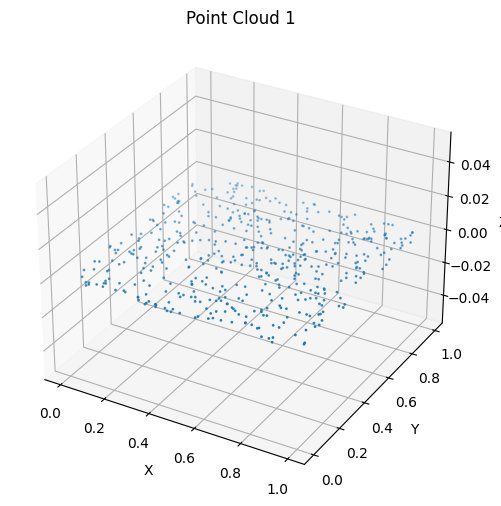

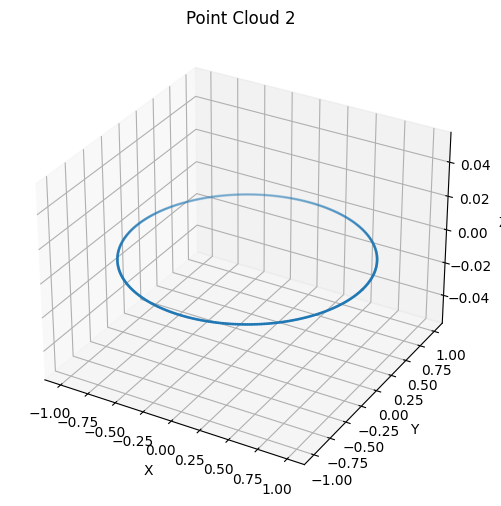

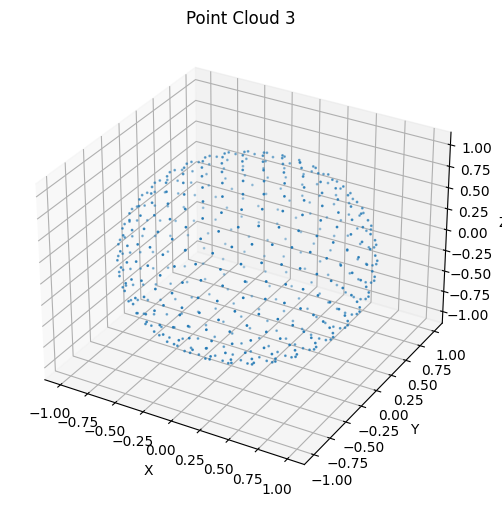

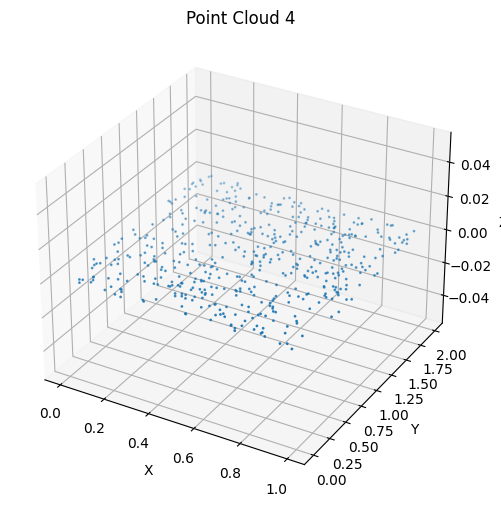

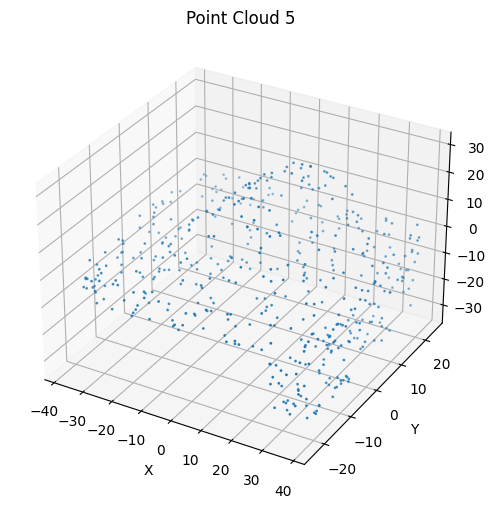

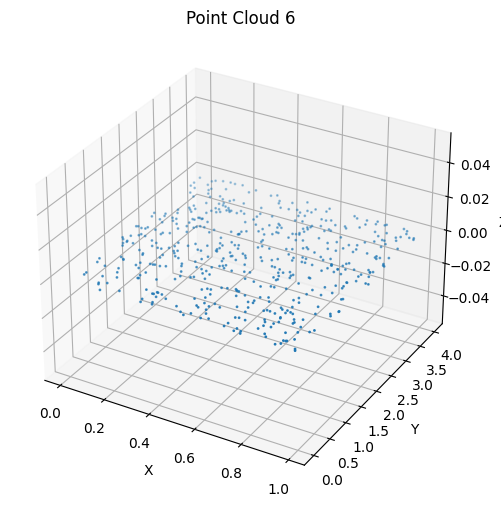

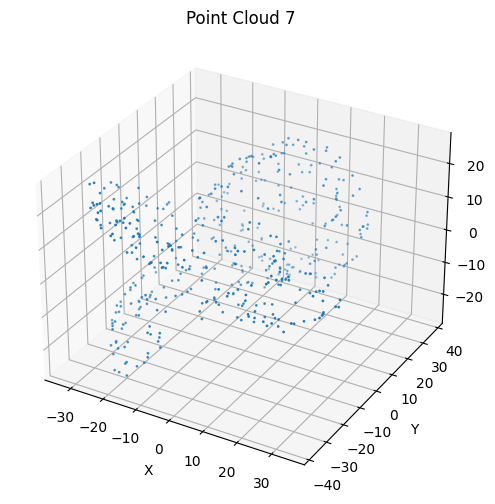

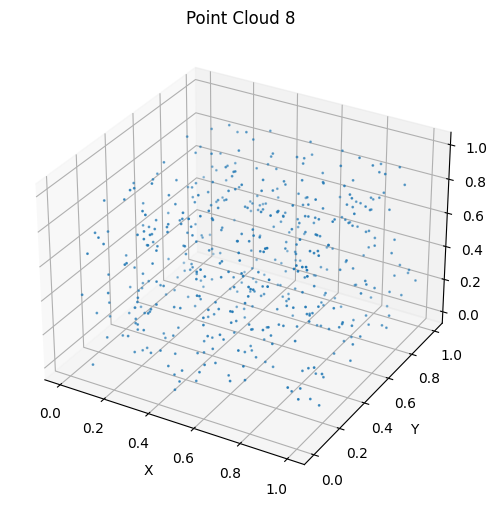

In [3]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()


Epoch 1/50, Loss: 0.3332982063293457
Epoch 11/50, Loss: 0.08534964174032211
Epoch 21/50, Loss: 0.010951679199934006
Epoch 31/50, Loss: 0.005743975285440683
Epoch 41/50, Loss: 0.0010831464314833283


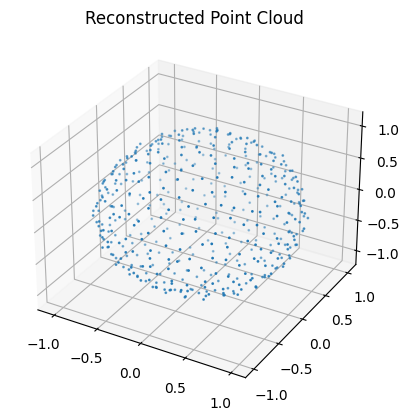

Skipping PCA due to a single data point.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self, output_size=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

# PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 3)

# PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder(output_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded, latent_vector

# Visualization function for point clouds
def plot_point_cloud(points, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    ax.set_title(title)
    plt.show()

# Function to train the autoencoder
def train_autoencoder(point_cloud_data, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    point_cloud_data = point_cloud_data.to(device).unsqueeze(0).permute(0, 2, 1)

    model = PointNetAutoencoder(num_points=point_cloud_data.shape[-1], latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output, _ = model(point_cloud_data)
        loss = criterion(output, point_cloud_data.squeeze().permute(1, 0))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Visualizing the result and latent space
    with torch.no_grad():
        decoded_pc, latent_vector = model(point_cloud_data)
        decoded_pc = decoded_pc.view(point_cloud_data.shape[-1], 3).cpu().numpy()
        plot_point_cloud(decoded_pc, "Reconstructed Point Cloud")


                # Assuming latent_vector is the output from your model
        if latent_vector.dim() == 1 or latent_vector.size(0) == 1:
            print("Skipping PCA due to a single data point.")
        else:
            # PCA on latent vector for visualization
            pca = PCA(n_components=2)
            latent_vector_2d = pca.fit_transform(latent_vector.cpu().numpy())
            plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1])
            plt.title('Latent Space Representation (2D)')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
            plt.show()


# Example: Load your point cloud data here
point_cloud_data = point_clouds[2]

# Train the autoencoder
train_autoencoder(point_cloud_data, epochs=50, latent_size=128)


Loss: 0.23034189641475677
Loss: 0.05338985100388527
Loss: 0.008779560215771198
Loss: 0.0038015092723071575
Loss: 0.0011444673873484135
Loss: 0.00046459122677333653
Loss: 0.00011375243775546551
Loss: 6.532688712468371e-05
Loss: 2.312039396201726e-05
Loss: 6.429476798075484e-06
Loss: 1.89709908227087e-06
Loss: 6.747374072801904e-07
Loss: 2.3743747590287967e-07
Loss: 8.688613917229304e-08
Loss: 3.071323462222608e-08
Loss: 1.1887687278999692e-08
Loss: 5.324443108634114e-09
Loss: 2.2083541661999107e-09
Loss: 7.366003917930186e-10
Loss: 1.8631390874546128e-10
Loss: 7.366610793591022e-11
Loss: 3.439398071902744e-11
Loss: 8.844577847888502e-12
Loss: 3.305591911306749e-12
Loss: 1.3881497947648702e-12
Loss: 3.574516171337555e-13
Loss: 1.2609761867489466e-13
Loss: 4.154910736211409e-14
Loss: 1.906912738065987e-14
Loss: 5.355640247690224e-15
Loss: 2.030960332026553e-15
Loss: 1.0154484022777545e-15
Loss: 5.997311433311259e-16
Loss: 3.6388911284915087e-16
Loss: 2.57462017065049e-16
Loss: 7.154257854

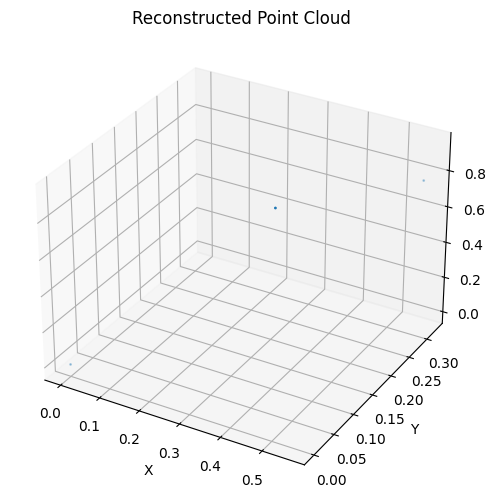

Loss: 0.5638392567634583
Loss: 0.12625153362751007
Loss: 0.007342697121202946
Loss: 0.0030062999576330185
Loss: 0.0009503774926997721
Loss: 0.0003141174674965441
Loss: 9.993439743993804e-05
Loss: 3.727235525730066e-05
Loss: 1.2758830962411594e-05
Loss: 4.447289029485546e-06
Loss: 1.5774309076732607e-06
Loss: 5.376267040446692e-07
Loss: 1.7813870556437905e-07
Loss: 5.567979499687681e-08
Loss: 1.615450351266645e-08
Loss: 4.105728645953377e-09
Loss: 1.0172975795086359e-09
Loss: 3.309410245844191e-10
Loss: 1.4999629316392316e-10
Loss: 8.81665851437674e-11
Loss: 4.18145587599561e-11
Loss: 1.4826995534122922e-11
Loss: 3.862373528645824e-12
Loss: 7.615619289705333e-13
Loss: 2.1969451540100604e-13
Loss: 1.1215149224889573e-13
Loss: 3.3219927459901544e-14
Loss: 1.3970617536635845e-14
Loss: 3.723876591067493e-15
Loss: 2.0004881099908427e-15
Loss: 8.831082392965386e-16
Loss: 5.493398298099875e-16
Loss: 4.023525348768338e-16
Loss: 2.4752150309386854e-16
Loss: 2.022664385462026e-16
Loss: 1.54176897

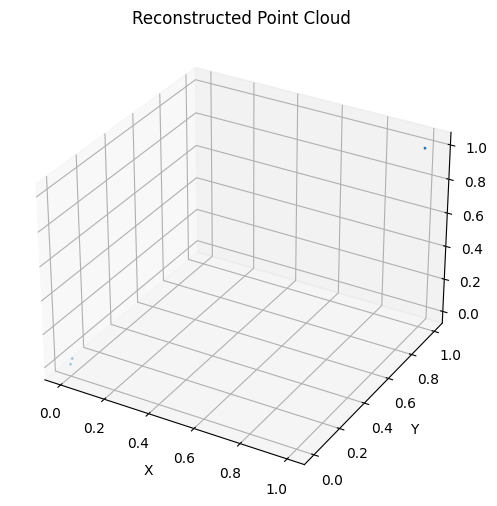

Loss: 0.4681587815284729
Loss: 0.13773564994335175
Loss: 0.012788261286914349
Loss: 0.0018188530812039971
Loss: 0.0005098039982840419
Loss: 0.00019531726138666272
Loss: 4.942754821968265e-05
Loss: 1.1531900781847071e-05
Loss: 7.937960617709905e-06
Loss: 1.6124910189319053e-06
Loss: 5.647927991958568e-07
Loss: 3.225526654659916e-07
Loss: 5.730621666089064e-08
Loss: 2.792847197952142e-08
Loss: 1.375504066203348e-08
Loss: 2.7287072601467344e-09
Loss: 1.2331703436174735e-09
Loss: 5.665470870219735e-10
Loss: 1.2889772582624914e-10
Loss: 4.594593802642599e-11
Loss: 2.3008846564143148e-11
Loss: 6.339651893727538e-12
Loss: 1.7387543228136737e-12
Loss: 8.86468578664007e-13
Loss: 2.877374716530462e-13
Loss: 7.035091774540078e-14
Loss: 3.8769978709645575e-14
Loss: 1.2093315545746563e-14
Loss: 4.049104208528201e-15
Loss: 1.9310767245786682e-15
Loss: 1.2745027354045231e-15
Loss: 7.426130019178359e-16
Loss: 4.944399716688512e-16
Loss: 3.643607513820939e-16
Loss: 3.0580110210388825e-16
Loss: 2.579429

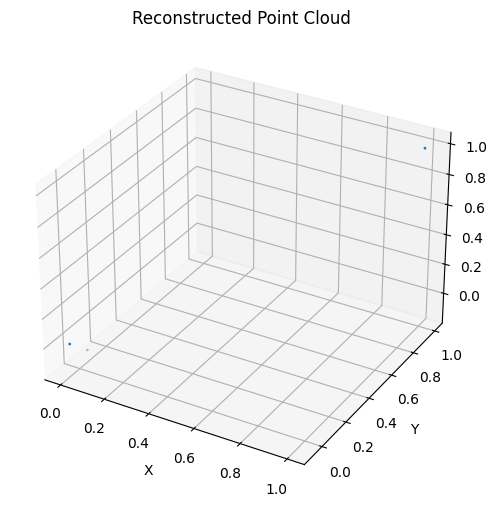

Loss: 0.9270557165145874
Loss: 0.2978278398513794
Loss: 0.022426467388868332
Loss: 0.0038129063323140144
Loss: 0.0011632285313680768
Loss: 0.0002998218988068402
Loss: 9.054544352693483e-05
Loss: 4.578812877298333e-05
Loss: 1.1378640920156613e-05
Loss: 4.841866029892117e-06
Loss: 1.8847856608772418e-06
Loss: 4.846591536988853e-07
Loss: 2.2797286192144384e-07
Loss: 8.1477146807174e-08
Loss: 1.985715059049653e-08
Loss: 9.195407990603144e-09
Loss: 3.5739504689047408e-09
Loss: 8.949243568423526e-10
Loss: 3.487554134373738e-10
Loss: 1.5865814217974616e-10
Loss: 4.570317041485694e-11
Loss: 1.2646935582116825e-11
Loss: 5.3460378485192805e-12
Loss: 2.3769814241902942e-12
Loss: 6.955863836310971e-13
Loss: 2.436489595150637e-13
Loss: 6.909500505384789e-14
Loss: 2.7015660148950287e-14
Loss: 1.1041080396690436e-14
Loss: 5.19974383374807e-15
Loss: 3.100207926070046e-15
Loss: 2.2910981261719783e-15
Loss: 1.8547842552612366e-15
Loss: 1.5579772401588701e-15
Loss: 1.4777348444501548e-15
Loss: 1.35578009

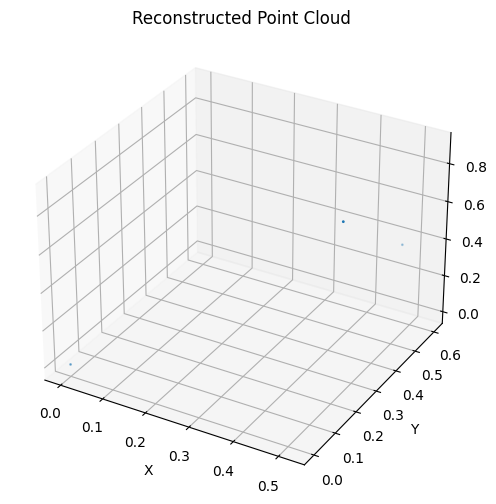

Loss: 386.5121765136719
Loss: 45.13064193725586
Loss: 4.667468070983887
Loss: 0.6511930227279663
Loss: 0.1668834388256073
Loss: 0.050544098019599915
Loss: 0.0163655336946249
Loss: 0.005829583387821913
Loss: 0.0019595653284341097
Loss: 0.0006343752611428499
Loss: 0.00018946288037113845
Loss: 7.318941061384976e-05
Loss: 3.1650837627239525e-05
Loss: 1.2882365808764007e-05
Loss: 4.0149329834093805e-06
Loss: 1.008372123578738e-06
Loss: 5.392676030169241e-07
Loss: 1.8911676136212918e-07
Loss: 4.349404392200995e-08
Loss: 2.5313621421219068e-08
Loss: 5.443196116061699e-09
Loss: 3.3360838536111714e-09
Loss: 6.769365068493016e-10
Loss: 2.422178846384071e-10
Loss: 8.094302311745238e-11
Loss: 3.398053366465703e-11
Loss: 1.3209108286338367e-11
Loss: 4.214703239191486e-12
Loss: 3.549618715278924e-12
Loss: 3.5021269738366723e-12
Loss: 9.57058976340519e-13
Loss: 5.032284810212173e-13
Loss: 3.180935603894902e-13
Loss: 3.385468988481577e-13
Loss: 2.5418350150380187e-13
Loss: 3.261786457250948e-13
Loss: 

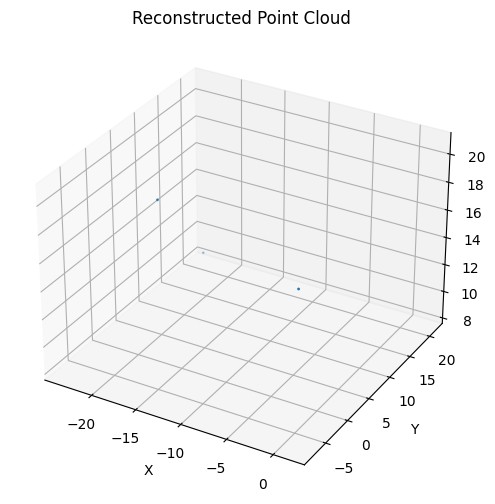

Loss: 2.2469449043273926
Loss: 1.5780243873596191
Loss: 0.48047399520874023
Loss: 0.07304689288139343
Loss: 0.017696574330329895
Loss: 0.006785855162888765
Loss: 0.0024077766574919224
Loss: 0.0008685579523444176
Loss: 0.0002460704417899251
Loss: 8.850348967825994e-05
Loss: 3.866793849738315e-05
Loss: 1.2735731615975965e-05
Loss: 3.6779888432647567e-06
Loss: 1.3819524156133411e-06
Loss: 5.411944812294678e-07
Loss: 1.8821761216258892e-07
Loss: 5.6301967532590425e-08
Loss: 2.0927299004824818e-08
Loss: 8.368429504912456e-09
Loss: 2.6059272517642285e-09
Loss: 8.402959439379742e-10
Loss: 3.353493871482982e-10
Loss: 1.2218301370658935e-10
Loss: 3.611968710237612e-11
Loss: 1.2955096197198035e-11
Loss: 5.060530987310852e-12
Loss: 1.774860857242655e-12
Loss: 5.950435456869574e-13
Loss: 2.1863797393644607e-13
Loss: 9.042566635796348e-14
Loss: 4.9725052227904756e-14
Loss: 3.284964531294343e-14
Loss: 2.8037878144421616e-14
Loss: 2.683153720907383e-14
Loss: 2.390694589450744e-14
Loss: 2.309982005753

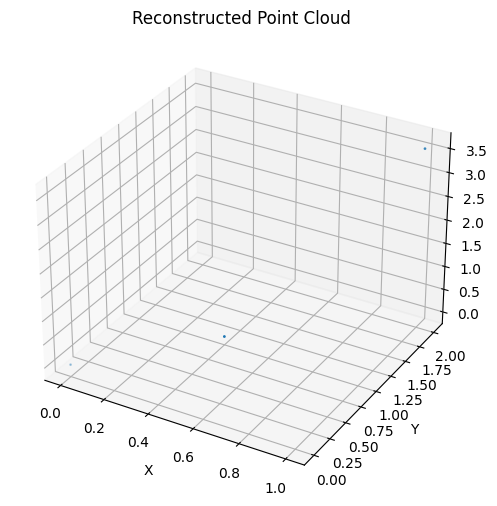

Loss: 414.029296875
Loss: 281.0668029785156
Loss: 86.06749725341797
Loss: 13.407201766967773
Loss: 2.3608081340789795
Loss: 0.7342885136604309
Loss: 0.17476558685302734
Loss: 0.05955520272254944
Loss: 0.017961779609322548
Loss: 0.006578437983989716
Loss: 0.0021982542239129543
Loss: 0.0008337243343703449
Loss: 0.0002823213580995798
Loss: 0.00010332207602914423
Loss: 3.2446609111502767e-05
Loss: 1.2073461221007165e-05
Loss: 4.027365321235266e-06
Loss: 1.639336460357299e-06
Loss: 5.477028253153549e-07
Loss: 2.0046668680606672e-07
Loss: 7.180487671121227e-08
Loss: 2.5345885390493095e-08
Loss: 8.79782202645174e-09
Loss: 3.208010079802648e-09
Loss: 1.109875302773844e-09
Loss: 3.9899958337308306e-10
Loss: 1.2780834723891132e-10
Loss: 4.305557993466991e-11
Loss: 1.4932983669058153e-11
Loss: 7.1085962637107425e-12
Loss: 3.76571300184092e-12
Loss: 2.5747182164082005e-12
Loss: 1.9512195678639266e-12
Loss: 1.6825787724911168e-12
Loss: 1.3923860979134228e-12
Loss: 1.340181871728463e-12
Loss: 1.2984

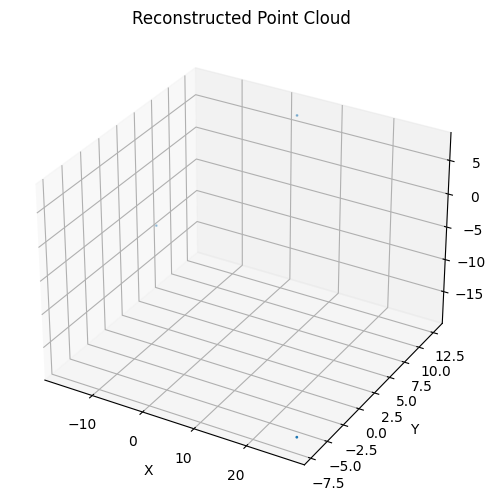

Loss: 4.014725208282471
Loss: 0.36168307065963745
Loss: 0.3071271479129791
Loss: 0.059158265590667725
Loss: 0.011689583770930767
Loss: 0.004128697793930769
Loss: 0.0011824712855741382
Loss: 0.0004658551188185811
Loss: 0.00014432395983021706
Loss: 5.1912858907599e-05
Loss: 1.7179314454551786e-05
Loss: 6.142525762697915e-06
Loss: 2.114642711603665e-06
Loss: 7.311255671993422e-07
Loss: 2.639440026541706e-07
Loss: 8.846186005939671e-08
Loss: 3.23375139998916e-08
Loss: 1.0878713929685091e-08
Loss: 4.089599325851623e-09
Loss: 1.3983154634189532e-09
Loss: 5.074708986363419e-10
Loss: 1.7197533674906396e-10
Loss: 6.325111268079553e-11
Loss: 2.2544070776842062e-11
Loss: 7.776854681063039e-12
Loss: 2.7570055613490574e-12
Loss: 9.534207191103095e-13
Loss: 3.667696571799106e-13
Loss: 1.2041606047789172e-13
Loss: 4.103291870779374e-14
Loss: 1.3443032901043137e-14
Loss: 5.638099901094642e-15
Loss: 3.700196514477578e-15
Loss: 2.9063129788393536e-15
Loss: 2.625929614946893e-15
Loss: 2.511739621019883e-

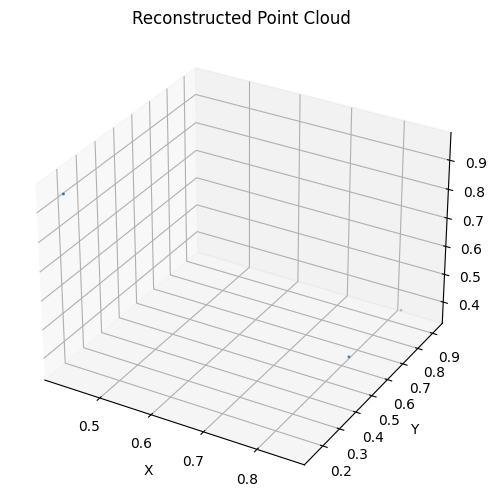

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os
from plyfile import PlyData

# Function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self, output_size=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

# PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetDecoder, self).__init__()
        self.num_points = num_points
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, self.num_points, 3)

# PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder(output_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded, latent_vector

# # Function to train the autoencoder incrementally on an array of point clouds
# def train_autoencoder_incrementally(point_clouds, epochs=50, latent_size=128):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = PointNetAutoencoder(num_points=point_clouds[0].shape[0], latent_size=latent_size).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.MSELoss()

#     for point_cloud in point_clouds:
#         point_cloud_data = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)  # Adjust dimensions for model input
#         for epoch in range(epochs):
#             optimizer.zero_grad()
#             output, _ = model(point_cloud_data)
#             loss = criterion(output, point_cloud_data.squeeze().permute(1, 0))
#             loss.backward()
#             optimizer.step()
#             if epoch % 10 == 0:
#                 print(f"Loss: {loss.item()}")

#         # Visualize the reconstructed point cloud after training on each
#         with torch.no_grad():
#             decoded_pc, _ = model(point_cloud_data)
#             decoded_pc = decoded_pc.squeeze().permute(1, 0).cpu().numpy()
#             plot_point_cloud(decoded_pc, "Reconstructed Point Cloud")


# Function to train the autoencoder incrementally on an array of point clouds
def train_autoencoder_incrementally(point_clouds, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetAutoencoder(num_points=point_clouds[0].shape[0], latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for point_cloud in point_clouds:
        # Adjusting dimensions for model input, ensure point_cloud is [num_points, 3]
        point_cloud_data = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)  # Shape becomes [1, 3, num_points]
        for epoch in range(epochs):
            optimizer.zero_grad()
            output, _ = model(point_cloud_data)  # output shape [1, num_points, 3] after decoder adjustment
            # Ensure target tensor is correctly shaped for loss calculation
            loss = criterion(output, point_cloud_data.permute(0, 2, 1))  # Correct the target tensor shape
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0:
                print(f"Loss: {loss.item()}")

        # Visualize the reconstructed point cloud after training on each
        with torch.no_grad():
            decoded_pc, _ = model(point_cloud_data)
            decoded_pc = decoded_pc.permute(0, 2, 1).squeeze().cpu().numpy()  # Adjusting permute to match original shape
            plot_point_cloud(decoded_pc, "Reconstructed Point Cloud")


# Train the autoencoder incrementally on the array of point clouds
train_autoencoder_incrementally(point_clouds, epochs=500, latent_size=128)


NaN detected at epoch 0
Reconstruction resulted in NaN values.
NaN detected at epoch 0
Reconstruction resulted in NaN values.
Epoch 0/50, Loss: 0.08433425426483154
Epoch 10/50, Loss: 0.01692427322268486
Epoch 20/50, Loss: 0.0029705450870096684
Epoch 30/50, Loss: 0.0009334043134003878
Epoch 40/50, Loss: 0.00026470000739209354


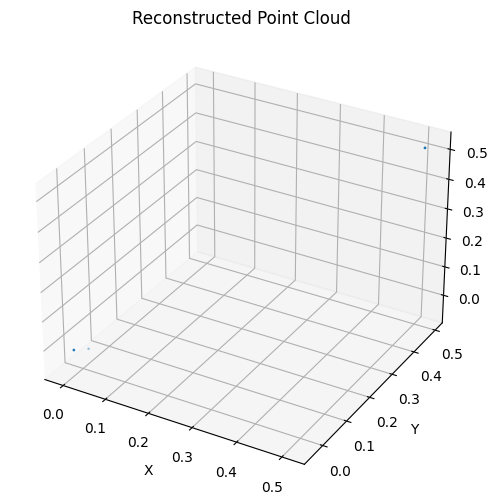

NaN detected at epoch 0
Reconstruction resulted in NaN values.
Epoch 0/50, Loss: 0.1787497103214264
Epoch 10/50, Loss: 0.076238252222538
Epoch 20/50, Loss: 0.028043320402503014
Epoch 30/50, Loss: 0.0032765038777142763
Epoch 40/50, Loss: 0.0008287025848403573


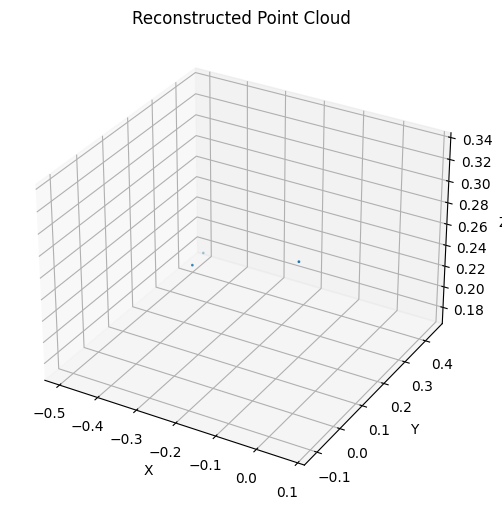

NaN detected at epoch 0
Reconstruction resulted in NaN values.
Epoch 0/50, Loss: 0.17169325053691864
Epoch 10/50, Loss: 0.06779545545578003
Epoch 20/50, Loss: 0.027277251705527306
Epoch 30/50, Loss: 0.003940246999263763
Epoch 40/50, Loss: 0.000903127365745604


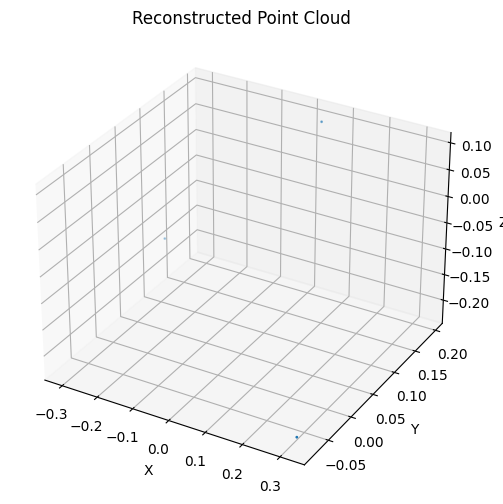

Epoch 0/50, Loss: 0.16212166845798492
Epoch 10/50, Loss: 0.07953842729330063
Epoch 20/50, Loss: 0.05751226469874382
Epoch 30/50, Loss: 0.018472785130143166
Epoch 40/50, Loss: 0.0025657578371465206


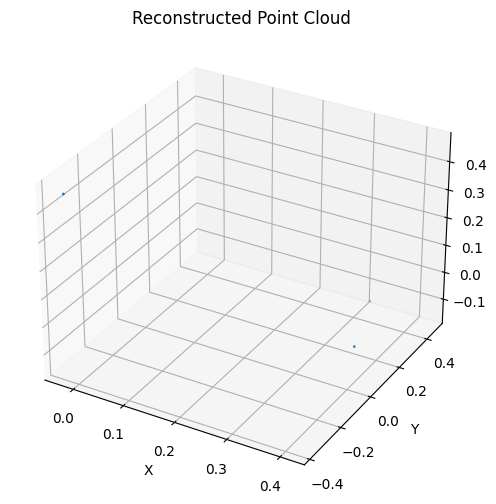

In [12]:
# Assuming all previous code remains the same

# Normalize point clouds (example normalization to unit cube)
def normalize_point_clouds(point_clouds):
    normalized_point_clouds = []
    for pc in point_clouds:
        pc_min = pc.min(0, keepdim=True)[0]
        pc_max = pc.max(0, keepdim=True)[0]
        pc = (pc - pc_min) / (pc_max - pc_min) - 0.5  # Normalize to [-0.5, 0.5]
        normalized_point_clouds.append(pc)
    return normalized_point_clouds

def train_autoencoder_incrementally(point_clouds, epochs=50, latent_size=128, initial_lr=0.0001):  # Reduced LR
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetAutoencoder(num_points=point_clouds[0].shape[0], latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    criterion = nn.MSELoss()

    for point_cloud in point_clouds:
        point_cloud_data = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)
        for epoch in range(epochs):
            optimizer.zero_grad()
            output, _ = model(point_cloud_data)
            loss = criterion(output, point_cloud_data.permute(0, 2, 1))
            if torch.isnan(loss):
                print(f"NaN detected at epoch {epoch}")
                break  # Stop training if NaN detected
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

        with torch.no_grad():
            decoded_pc, _ = model(point_cloud_data)
            decoded_pc = decoded_pc.permute(0, 2, 1).squeeze().cpu().numpy()
            if not np.isnan(decoded_pc).any():
                plot_point_cloud(decoded_pc, "Reconstructed Point Cloud")
            else:
                print("Reconstruction resulted in NaN values.")


# Normalize your point clouds
normalized_point_clouds = normalize_point_clouds(point_clouds)

# Train the autoencoder incrementally on the array of normalized point clouds
train_autoencoder_incrementally(normalized_point_clouds, epochs=50, latent_size=128, initial_lr=0.001)
